# Electricity switches - time series analysis

1. Input data
    - Reading the data
    - renaming the variables
    - creating a new vartiable
2. Plotting the trends
3. Asssumptions check: 
    - Stationarity
    - Autoccorrelation
    - Decomposition
4. Forecast
    - Train test split
    - using auto-arima method
    - forecast plot and RSME calculation

5. Further steps

Sources:
- https://builtin.com/data-science/time-series-python
- https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd
- https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

## 1. Input data

### 1.1 Reading the data

In [127]:
# average_tariffs=pd.read_excel('2nd Stage Data Analyst Assessment - Data Tables.xlsx'
#                            ,sheet_name='Average tariffs ')
# average_tariffs

In [6]:
electricity_switches=pd.read_excel('2nd Stage Data Analyst Assessment - Data Tables.xlsx'
                           ,sheet_name='Electricity switches')
electricity_switches

,Month,Total electricity switches (both switching tariff and/or switching supplier),Total electricity switches to different suppliers
0,2012-01-01,210000,22337
1,2012-02-01,257000,29128
2,2012-03-01,279000,20817
3,2012-04-01,232000,12872
4,2012-05-01,286000,19167
...,...,...,...
74,2018-03-01,443326,221536
75,2018-04-01,446530,266409
76,2018-05-01,464753,320163
77,2018-06-01,455194,348591


In [20]:
electricity_switches.dtypes

Month                                                                           datetime64[ns]
Total electricity switches (both switching tariff and/or switching supplier)             int64
Total electricity switches to different suppliers                                        int64
dtype: object

In [15]:
electricity_switches.head()

,Month,Total electricity switches (both switching tariff and/or switching supplier),Total electricity switches to different suppliers
0,2012-01-01,210000,22337
1,2012-02-01,257000,29128
2,2012-03-01,279000,20817
3,2012-04-01,232000,12872
4,2012-05-01,286000,19167


In [19]:
electricity_switches['Month'] = pd.to_datetime(electricity_switches['Month'], format='%Y-%m-%d')

### 1.2 Renaming variables and 1.3 Creating tariff_switches

In [107]:
electricity_switches = electricity_switches.rename(columns={
                                        "Total electricity switches (both switching tariff and/or switching supplier)": "total_switches", 
                                        "Total electricity switches to different suppliers": "supplier_switches"
                                        })

electricity_switches['tariff_switches'] = electricity_switches.total_switches-electricity_switches.supplier_switches

electricity_switches_monthly_df = electricity_switches.set_index('Month', drop=True, inplace=False)
electricity_switches_monthly_df

,total_switches,supplier_switches,tariff_switches
Month,,,
2012-01-01,210000,22337,187663
2012-02-01,257000,29128,227872
2012-03-01,279000,20817,258183
2012-04-01,232000,12872,219128
2012-05-01,286000,19167,266833
...,...,...,...
2018-03-01,443326,221536,221790
2018-04-01,446530,266409,180121
2018-05-01,464753,320163,144590


## 2. Plot of trends

<AxesSubplot: xlabel='Month'>

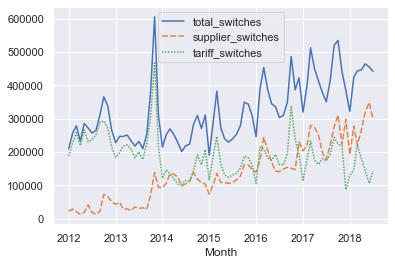

In [125]:
sns.lineplot(electricity_switches_monthly_df)

In [109]:
total_switches_monthly_df = electricity_switches_monthly_df[['total_switches']]
total_switches_monthly_df.head()

,total_switches
Month,
2012-01-01,210000
2012-02-01,257000
2012-03-01,279000
2012-04-01,232000
2012-05-01,286000


## 3. Assumptions check 
### 3.1 Stationarity

Stationarity is a key part of time series analysis. Simply put, stationarity means that the manner in which time series data changes is constant. A stationary time series will not have any trends or seasonal patterns. One should check for stationarity because it not only makes modeling time series easier, but it is an underlying assumption in many time series methods. Specifically, stationarity is assumed for a wide variety of time series forecasting methods including autoregressive moving average (ARMA), ARIMA and Seasonal ARIMA (SARIMA).

The Dickey Fuller test checks for stationarity, ie Ho= Data is stationary. This test will generate critical values and a p-value, which allows to reject or not-reject the null hypothesis that there is no stationarity. Fail to reject the null hypothesis, means there is not enough evidence to state that the data is not stationarity (meaning statitionarity is likely present).

In [110]:
plot_df = total_switches_monthly_df.assign(
    rolling_mean=total_switches_monthly_df.total_switches.rolling(7).mean(),
    rolling_std=total_switches_monthly_df.total_switches.rolling(7).std()
)

In [98]:
plot_df.head(10)

,total_switches,rolling_mean,rolling_std
Month,,,
2012-01-01,210000,NaN,NaN
2012-02-01,257000,NaN,NaN
2012-03-01,279000,NaN,NaN
2012-04-01,232000,NaN,NaN
2012-05-01,286000,NaN,NaN
2012-06-01,272000,NaN,NaN
2012-07-01,257000,256142.857143,27014.987022
2012-08-01,265000,264000.000000,17776.388835
2012-09-01,312000,271857.142857,24895.974048


<AxesSubplot: xlabel='Month'>

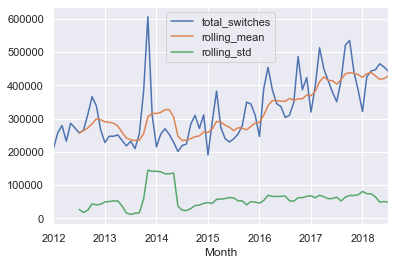

In [111]:
plot_df.plot()

This graph, shows that the 7 months rolling mean smooths out the trend of the total switches and the standard deviation does not change dramatically, except in both cases for data pre 2014 and specifically for the outlier point known (Nov 2013) when new regulation from Ofgem came into place. This is an indication that the data previous to this point should be left out of the analysis as it could mess up with the forecast.  

In [112]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(total_switches_monthly_df.total_switches,autolag="AIC")

In [113]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']], 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", "critical value (1%)", "critical value (5%)", "critical value (10%)"]
                         })
print(output_df)

      Values                       Metric
0   0.765680              Test Statistics
1   0.991061                      p-value
2  11.000000             No. of lags used
3  67.000000  Number of observations used
4  -3.531955          critical value (1%)
5  -2.905755          critical value (5%)
6  -2.590357         critical value (10%)


This test fails to reject H0, with p-value greater than 5% and the test statistic is greater than the critical values.
Meaning there is enouth evidence to state that stationairy is likely present in the data

### 3.2 Autocorrelation

Checking time series data for autocorrelation in Python is another important part of the analytic process. 
This is a measure of how correlated the time series data is at a given point in time with past values, which has huge implications across many industries. 
In this case, if the data has strong autocorrelation, it can be assumed that high switching numbers today suggest a strong likelihood that they will be high tomorrow as well.

In [114]:
autocorrelation_lag1 = total_switches_monthly_df.total_switches.autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = total_switches_monthly_df.total_switches.autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = total_switches_monthly_df.total_switches.autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = total_switches_monthly_df.total_switches.autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)


One Month Lag:  0.6963247075757062
Three Month Lag:  0.34691534813975494
Six Month Lag:  0.4811617106662385
Nine Month Lag:  0.271330374364299


The lags calculated suggest there is enough autocorrelation at one momth lag, 6 month lag might also have enough autocorrelation, but the other lags are not very high.<br>
This is important to bear in mind for further analysis or if the data frame changes but as it is now on a monthly basis let's continue with the analysis.

### 3.3 Decomposition

Trend decomposition is another useful way to visualize the trends in time series data

In [115]:
from statsmodels.tsa.seasonal import seasonal_decompose

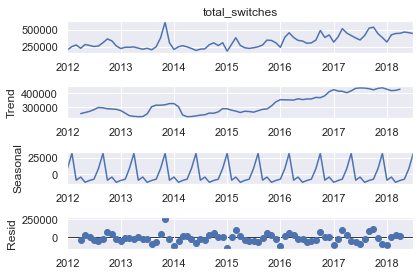

In [116]:
decompose = seasonal_decompose(total_switches_monthly_df.total_switches,model='additive', period=7)
decompose.plot()
plt.show()

From this plot, we can see the increasing trend in the number of switches from 2015 onwards and the seasonality patterns in the rise and fall in values each year.

## 4.Forecasting

This section focus on the split of the data into train and test and on the use of the arima module from the library pmdarima.arima for the forecast

In [117]:
total_switches_monthly_df.tail(10)

,total_switches
Month,
2017-10-01,534746
2017-11-01,440757
2017-12-01,385060
2018-01-01,321560
2018-02-01,425147
2018-03-01,443326
2018-04-01,446530
2018-05-01,464753
2018-06-01,455194


### 4.1 Train and test split

In [118]:
before_2017 = total_switches_monthly_df.index < pd.Timestamp("2017-01-01")
ge_2014 = total_switches_monthly_df.index >= pd.Timestamp("2014-01-01")
train = total_switches_monthly_df.loc[before_2017 & ge_2014]
test = total_switches_monthly_df.loc[~before_2017]
#train, test

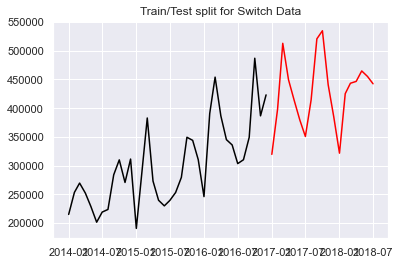

In [119]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.title("Train/Test split for Switch Data")
sns.set()
plt.show()

### 4.2 Using auto-arima method

In [120]:
from pmdarima.arima import auto_arima
model = auto_arima(
    train,
    start_p=0,
    max_p=5, 
    start_q=0,
    max_q=5,
    d=1,
    max_d=5,
    start_P=1,
    max_P=5, 
    start_Q=1,
    max_Q=5, 
    D=1, 
    max_D=5,
    # The period for seasonal differencing, m refers to the number of periods in each season. 
    # For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data.
    m=12,
    random_state=1337,
    n_fits=50
)
model.fit(train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])

In [121]:
forecast

,Prediction
Month,
2017-01-01,231630.918036
2017-02-01,397769.221407
2017-03-01,487813.301163
2017-04-01,387417.209509
2017-05-01,342491.766987
2017-06-01,338974.759402
2017-07-01,304530.898346
2017-08-01,314610.505806
2017-09-01,342386.935258


### 4.3 Forecast plot and RSME calculation

<AxesSubplot: xlabel='Month'>

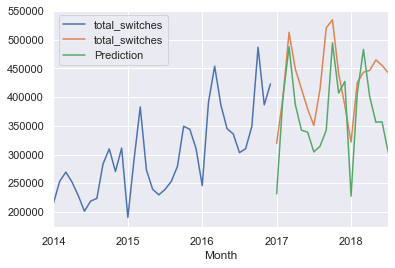

In [122]:
pd.concat([
    train,
    test,
    forecast
], axis="columns").plot()

In [123]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test,forecast))
print("RMSE: ", rms)

RMSE:  79769.68654296904


The forecast shows a very similar prediction to the one that actually happened, with the estimation even being on the pessimistic side which in general is good practice to do (depending on the industry).<br>
The predictions' error overal is 79,769 swtiches.

## 5. Further steps

- Modify code to create pipeline so that the other 2 variables can be used for forecasting wihtout modifying the entirity of the code and things run smoothly.
- Compare the new results of the tariff and supplier switchers with the total swtichers findings.
- Investigate the library a but more on detail.
- Found formal academic source for the arima procedure.
- Calculate confidence intervals for estiamtion error and find more error measure methods.